# Lab 02: Axes, Transformations & Statistics

## Objectives

**Objectives**

- Compute **mean, median, mode**, and understand when each is appropriate.
- Use **different means** (arithmetic, geometric, harmonic, contra‑harmonic) and know when to choose them.
- Compute **variance/standard deviation** (population vs sample).  
- Use **summary statistics in Pandas** and **normalize** data (min‑max, z‑score).
- Apply **2D geometric transformations** (translation, scaling, rotation) via **matrix multiplication**.
- Use **nonlinear axes** (log, square‑root) appropriately.  
- Work with Cartesian and Polar coordinates.

**Tools Used**

- Google Colab
- NumPy
- Pandas
- Matplotlib
- Seaborn

## Setup

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from skimage import data, transform, color, img_as_float
plt.rcParams['figure.figsize'] = (7, 4)
plt.rcParams['axes.grid'] = True

## Datasets & Tools

- **`iris`** (seaborn) — classic 4D numeric dataset by species.  
- **`tips`** (seaborn) — restaurant bills/tips; great for mean/median/mode demos.  
- **Synthetic 2D points** — to see transformation effects clearly.  
- **Images** from `skimage.data` — e.g., `camera()` grayscale.

We'll load everything below.

In [3]:
iris = sns.load_dataset('iris')
tips = sns.load_dataset('tips')

cam = data.camera()
astr = data.astronaut()

iris.head(), tips.head(), cam.shape, astr.shape

(   sepal_length  sepal_width  petal_length  petal_width species
 0           5.1          3.5           1.4          0.2  setosa
 1           4.9          3.0           1.4          0.2  setosa
 2           4.7          3.2           1.3          0.2  setosa
 3           4.6          3.1           1.5          0.2  setosa
 4           5.0          3.6           1.4          0.2  setosa,
    total_bill   tip     sex smoker  day    time  size
 0       16.99  1.01  Female     No  Sun  Dinner     2
 1       10.34  1.66    Male     No  Sun  Dinner     3
 2       21.01  3.50    Male     No  Sun  Dinner     3
 3       23.68  3.31    Male     No  Sun  Dinner     2
 4       24.59  3.61  Female     No  Sun  Dinner     4,
 (512, 512),
 (512, 512, 3))

---

## Part A — Summary Statistics & Normalization

### A.1 Mean, Median, Mode
**Definitions**  
- Arithmetic mean: $\bar{x} = \frac{1}{n}\sum_{i=1}^n x_i$  
- Median: middle value after sorting (robust to outliers).  
- Mode: most frequent value (well-defined for categorical; tricky for continuous).

**When not to use the mean?** In **skewed** distributions or with **heavy outliers**, the median often better represents "typical" values.

Mean:   59.82
Median: 51.56


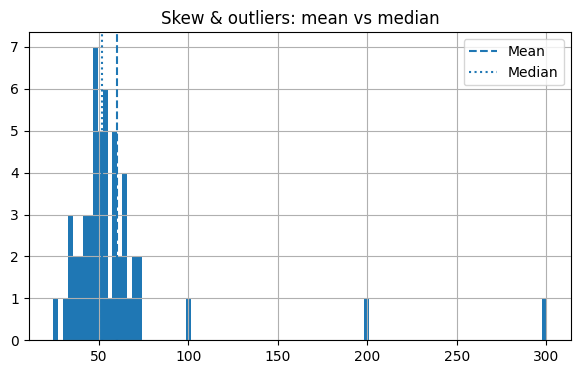

In [4]:
np.random.seed(0)
x = np.concatenate([np.random.normal(50, 10, size=50), np.array([100, 200, 300])])
mean_x = x.mean()
median_x = np.median(x)

print(f"Mean:   {mean_x:.2f}")
print(f"Median: {median_x:.2f}")

plt.hist(x, bins=100)
plt.axvline(mean_x, linestyle='--', label='Mean')
plt.axvline(median_x, linestyle=':', label='Median')
plt.legend()
plt.title('Skew & outliers: mean vs median')
plt.show()

### A.2 Different Means & When to Use Them
- **Arithmetic mean (AM):** ordinary average.  
- **Geometric mean (GM):** multiplicative processes (growth rates, ratios). $\left(\prod x_i\right)^{1/n}$ (requires positive values).  
- **Harmonic mean (HM):** rates/ratios like speeds, F1-score. $\frac{n}{\sum 1/x_i}$ (requires positive, nonzero).  
- **Contra-harmonic mean (CHM):** emphasizes larger values. $\frac{\sum x_i^2}{\sum x_i}$ (requires positive, nonzero).

In [5]:
def arithmetic_mean(x): return np.mean(x)
def geometric_mean(x): return np.exp(np.mean(np.log(x)))
def harmonic_mean(x): return len(x) / np.sum(1/np.array(x))
def contra_harmonic_mean(x, p=1): return np.sum(x**(p+1)) / np.sum(x**p)

def show_means(vals, label):
    print(f"\nDataset: {label}")
    print("Values:", vals)
    print("Arithmetic mean:", arithmetic_mean(vals))
    print("Geometric mean :", geometric_mean(vals))
    print("Harmonic mean  :", harmonic_mean(vals))
    print("Contra-harmonic mean (p=1):", contra_harmonic_mean(vals, p=1))

vals1 = np.array([10, 11, 12, 13, 100], dtype=float)
vals2 = np.array([10, 11, 12, 13, 1], dtype=float)

show_means(vals1, "Large outlier (100 among ~10s)")
show_means(vals2, "Small outlier (1 among ~10s)")


Dataset: Large outlier (100 among ~10s)
Values: [ 10.  11.  12.  13. 100.]
Arithmetic mean: 29.2
Geometric mean : 17.656452755992337
Harmonic mean  : 13.844068671743901
Contra-harmonic mean (p=1): 72.15068493150685

Dataset: Small outlier (1 among ~10s)
Values: [10. 11. 12. 13.  1.]
Arithmetic mean: 9.4
Geometric mean : 7.029160448699608
Harmonic mean  : 3.7005089278012595
Contra-harmonic mean (p=1): 11.382978723404255


> **Guideline:**  
> - Use **GM** for *ratios, indices, growth factors*.  
> - Use **HM** for *averaging rates* (e.g., speed, precision/recall harmonic).  
> - **CHM** when you want to **emphasize larger** values (less common, but useful with images/noise weighting).

### A.3 Variance & Standard Deviation (Population vs Sample)

- Population variance: $\sigma^2 = \frac{1}{N}\sum (x_i-\mu)^2$  
- Sample variance (unbiased): $s^2 = \frac{1}{n-1}\sum (x_i-\bar{x})^2$  

In pandas/numpy, use `ddof=0` for population, `ddof=1` for sample.

In [6]:
s = tips['total_bill']
pop_var = np.var(s, ddof=0)
samp_var = np.var(s, ddof=1)
pop_std = np.std(s, ddof=0)
samp_std = np.std(s, ddof=1)
print(f"Population var/std: {pop_var:.3f} / {pop_std:.3f}")
print(f"Sample     var/std: {samp_var:.3f} / {samp_std:.3f}")

Population var/std: 78.928 / 8.884
Sample     var/std: 79.253 / 8.902


### A.4 Summary Statistics in Pandas

In [7]:
summary = tips.groupby('day')['total_bill'].agg(['count','mean','median','std','min','max'])
display(summary)

C:\Users\mushf\AppData\Local\Temp\ipykernel_8644\2156808742.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  summary = tips.groupby('day')['total_bill'].agg(['count','mean','median','std','min','max'])


,count,mean,median,std,min,max
day,,,,,,
Thur,62,17.682742,16.20,7.886170,7.51,43.11
Fri,19,17.151579,15.38,8.302660,5.75,40.17
Sat,87,20.441379,18.24,9.480419,3.07,50.81
Sun,76,21.410000,19.63,8.832122,7.25,48.17


In [8]:
display(tips['total_bill'].describe())

count    244.000000
mean      19.785943
std        8.902412
min        3.070000
25%       13.347500
50%       17.795000
75%       24.127500
max       50.810000
Name: total_bill, dtype: float64

### A.5 Normalization: Min‑Max and Z‑score

In [9]:
def minmax_norm(x):
    x = pd.Series(x, dtype=float)
    return (x - x.min()) / (x.max() - x.min())

def zscore_norm(x, ddof=0):
    x = pd.Series(x, dtype=float)
    return (x - x.mean()) / x.std(ddof=ddof)

iris_norm = iris.copy()
iris_norm['sepal_length_mm'] = minmax_norm(iris['sepal_length'])
iris_norm['sepal_length_zz'] = zscore_norm(iris['sepal_length'], ddof=0)

iris_norm[['sepal_length','sepal_length_mm','sepal_length_zz']].head()

,sepal_length,sepal_length_mm,sepal_length_zz
0,5.1,0.222222,-0.900681
1,4.9,0.166667,-1.143017
2,4.7,0.111111,-1.385353
3,4.6,0.083333,-1.506521
4,5.0,0.194444,-1.021849


#### ✅ Your Turn — Stats & Normalization

1) For each `species` in **iris**, compute **AM, GM, HM, CHM, median, std (sample)** for `petal_length`. Present as a tidy table.  
2) Show how **min‑max** vs **z‑score** scaling change the shape of `sepal_width` distribution (plot both).

In [10]:
# TODO: Your code for A.Your Turn

---

## Part B — 2D Geometric Transformations

We will use **homogeneous coordinates** to express transformations as matrices.  

- **Translation** by $(t_x, t_y)$  
$$
T=\begin{bmatrix}1&0&t_x\\0&1&t_y\\0&0&1\end{bmatrix}
$$

- **Scaling** by $(s_x, s_y)$  
$$
S=\begin{bmatrix}s_x&0&0\\0&s_y&0\\0&0&1\end{bmatrix}
$$

- **Rotation** by $\theta$ (radians)  
$$
R=\begin{bmatrix}\cos\theta&-\sin\theta&0\\\sin\theta&\cos\theta&0\\0&0&1\end{bmatrix}
$$

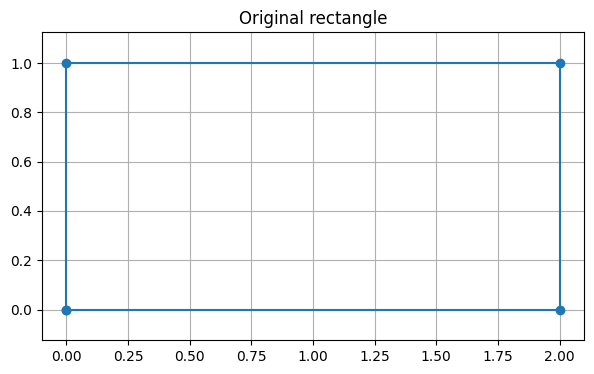

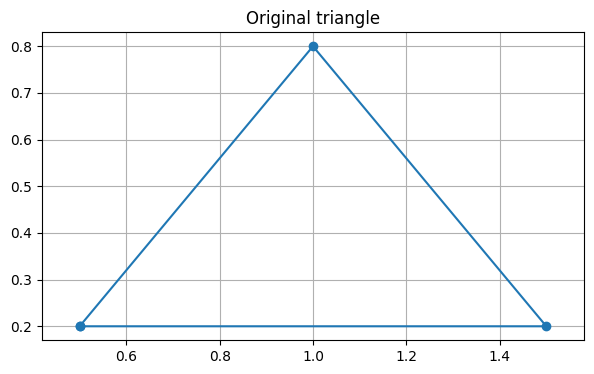

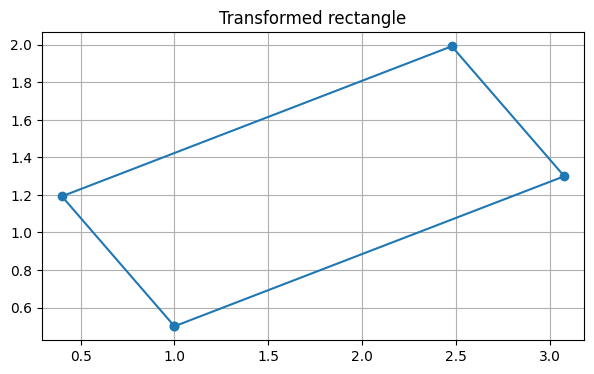

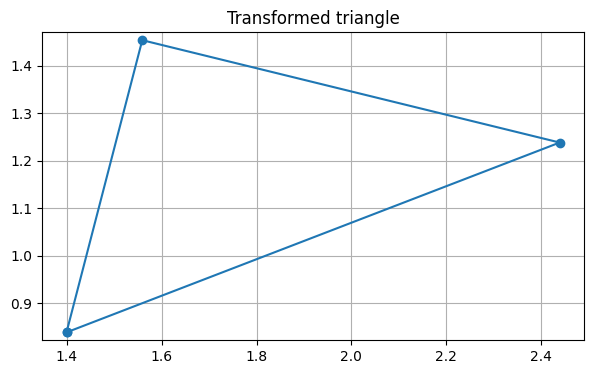

In [11]:
def to_homogeneous(pts):
    return np.hstack([pts, np.ones((pts.shape[0], 1))])

def from_homogeneous(pts_h):
    return pts_h[:, :2] / pts_h[:, 2, None]

def T_translate(tx, ty):
    return np.array([[1, 0, tx],
                     [0, 1, ty],
                     [0, 0, 1]], float)

def T_scale(sx, sy):
    return np.array([[sx, 0, 0],
                     [0, sy, 0],
                     [0, 0, 1]], float)

def T_rotate(theta_deg):
    th = np.deg2rad(theta_deg)
    return np.array([[np.cos(th), -np.sin(th), 0],
                     [np.sin(th),  np.cos(th), 0],
                     [0, 0, 1]], float)

def plot_shape(pts, title):
    plt.plot(pts[:, 0], pts[:, 1], marker='o')
    plt.axis('equal')
    plt.title(title)
    plt.show()

rect = np.array([[0, 0], [2, 0], [2, 1], [0, 1], [0, 0]], float)
triangle = np.array([[0.5, 0.2], [1.5, 0.2], [1.0, 0.8], [0.5, 0.2]], float)

plot_shape(rect, 'Original rectangle')
plot_shape(triangle, 'Original triangle')

M = T_translate(1, 0.5) @ T_scale(1.2, 0.8) @ T_rotate(30)
rect_t = from_homogeneous((M @ to_homogeneous(rect).T).T)
triangle_t = from_homogeneous((M @ to_homogeneous(triangle).T).T)

plot_shape(rect_t, 'Transformed rectangle')
plot_shape(triangle_t, 'Transformed triangle')

### B.1 Transformations on Images

Use `skimage.transform` to rotate, scale, and translate images.

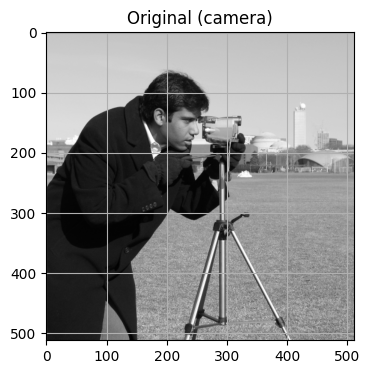

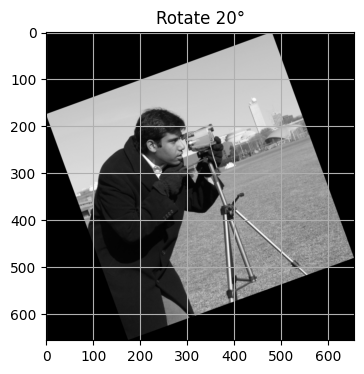

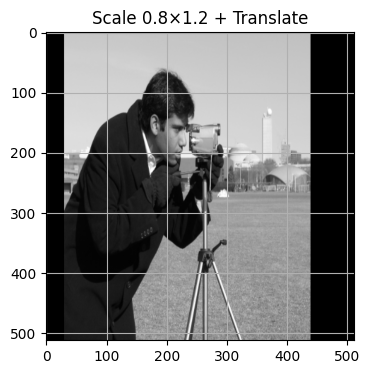

In [12]:
img = img_as_float(cam)
plt.imshow(img, cmap='gray')
plt.title('Original (camera)')
plt.show()

# Rotate
rot = transform.rotate(img, angle=20, resize=True)
plt.imshow(rot, cmap='gray')
plt.title('Rotate 20°')
plt.show()

# Scale + translate via Affine
M = transform.AffineTransform(scale=(0.8, 1.2), translation=(30, -15))
warp = transform.warp(img, M.inverse)
plt.imshow(warp, cmap='gray')
plt.title('Scale 0.8×1.2 + Translate')
plt.show()

#### ✅ Your Turn — Transformations

1) Create a **single matrix** that rotates by 45°, then scales by (0.5, 1.5), then translates by (2, −1). Apply it to a **circle** of sampled points.  
2) On the **`iris`** scatter (sepal_length vs sepal_width), apply a 30° rotation in data space and plot before/after. What changed?  
3) Apply a **shear** transform to the `camera` image (hint: `AffineTransform(shear=...)`) and discuss geometric distortion.

In [13]:
# TODO: Your code for B.Your Turn

---

## Part C — Nonlinear Axes (Log & Sqrt)

- **Logarithmic scale** reveals multiplicative relationships and compresses large ranges. (Requires **positive** values.)  
- **Square‑root scale** is ideal when mapping **area/size** so perceived area matches data.

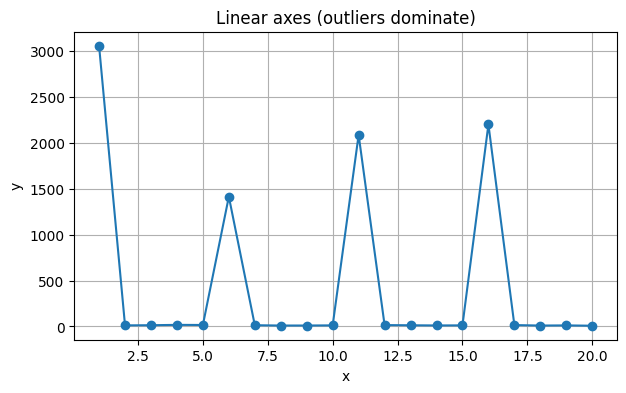

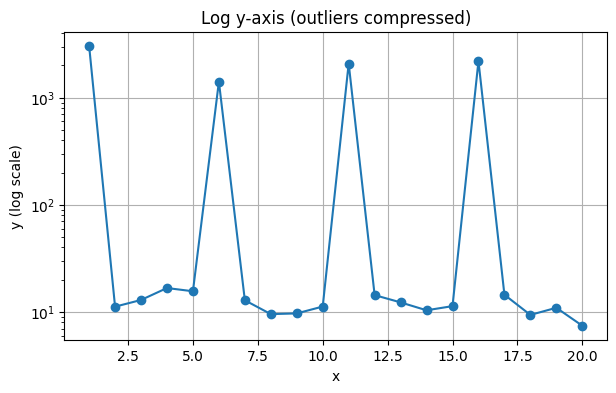

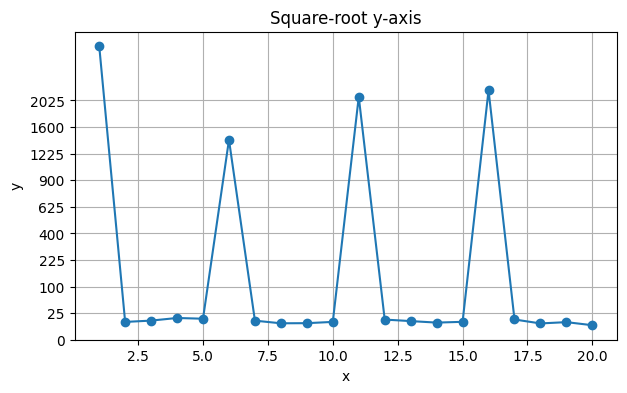

In [14]:
np.random.seed(0)
x = np.arange(1, 21)
y = np.random.normal(loc=10, scale=3, size=20)
y[::5] *= 200

# Linear scale
plt.plot(x, y, marker='o')
plt.title('Linear axes (outliers dominate)')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

# Log scale
plt.plot(x, y, marker='o')
plt.yscale('log')
plt.title('Log y-axis (outliers compressed)')
plt.xlabel('x'); plt.ylabel('y (log scale)')
plt.show()

# Square-root scale
plt.plot(x, np.sqrt(y), marker='o')
y_ticks = [n**2 for n in range(0, 50, 5)]
plt.yticks([np.sqrt(val) for val in y_ticks], y_ticks)
plt.title('Square-root y-axis')
plt.xlabel('x'); plt.ylabel('y')
plt.show()

#### ✅ Your Turn — Nonlinear Axes

Plot `total_bill` distribution (histogram) on **linear vs log x-axis**. Which better reveals tails?

In [15]:
# TODO: Your code for C.Your Turn

---

## Part D — Cartesian vs Polar Coordinates

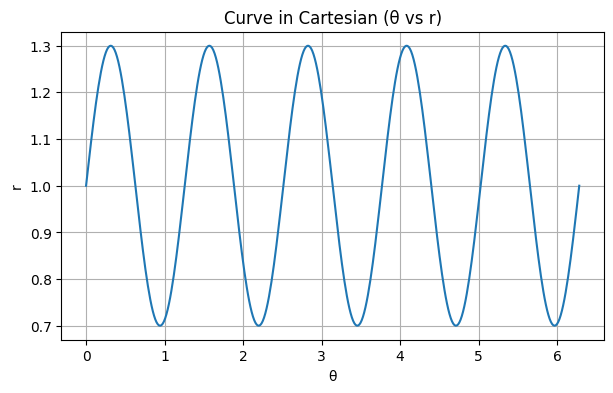

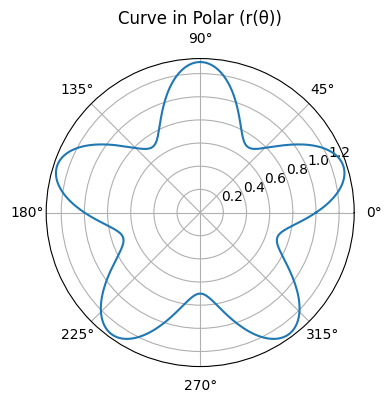

In [16]:
theta = np.linspace(0, 2*np.pi, 400)
r = 1 + 0.3*np.sin(5*theta)

# Cartesian view
plt.plot(theta, r)
plt.title('Curve in Cartesian (θ vs r)')
plt.xlabel('θ'); plt.ylabel('r')
plt.show()

# Polar view
ax = plt.subplot(111, projection='polar')
ax.plot(theta, r)
ax.set_title('Curve in Polar (r(θ))')
plt.show()

#### ✅ Your Turn — Polar

Convert a **circle** in Cartesian into polar coordinates and verify $r$ is constant.

In [17]:
# TODO: Your code for D.Your Turn

---

Draw the plot for the following temperature data in cartesian and polar coordinates.

In [18]:
months = np.arange(1, 13)
month_labels = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

A = np.array([25.4, 22.3, 20.1, 19.3, 20.6, 22.7, 25.6, 28.7, 31.1, 32.2, 30.8, 28.7])
B = np.array([27.9, 26.6, 24.9, 22.9, 21.8, 21.1, 22.0, 23.4, 25.1, 26.8, 27.9, 28.5])
C = np.array([16.7, 11.3, 4.5, -2.0, -6.7, -8.3, -6.7, -2.2, 4.5, 11.4, 16.8, 18.7])
D = np.array([10.7, 16.5, 24.7, 33.2, 39.2, 41.4, 39.6, 33.4, 25.1, 16.5, 10.8, 8.9])
E = np.array([24.5, 23.1, 21.6, 20.4, 19.8, 19.6, 20.0, 20.9, 22.1, 23.4, 24.6, 24.9])
F = np.array([27.9, 27.9, 27.8, 27.2, 25.8, 24.5, 23.8, 22.7, 22.0, 22.2, 22.5, 23.4])